In [1]:
from IPython.core.interactiveshell import InteractiveShell  #---- Output all jupyter lab inputs instead of the last one
from IPython.display import Markdown, display
InteractiveShell.ast_node_interactivity = "all"             
import glob #---------------------------------------------------- To read the files or folders in a system directory
from netCDF4 import Dataset #------------------------------------ To read nc , nc4 and hdf4 files
import numpy as np
import datetime
import h5py #---------------------------------------------------- To read hdf5 files
from scipy import spatial #-------------------------------------- To extract the values and indices of k nearest neighbors
import pandas as pd
from ast import literal_eval #----------------------------------- For literal evaluation of a string to extract python objects
from pyproj import Proj, transform #----------------------------- To interconvert different projections
import warnings #------------------------------------------------ To suppress warnings
from photutils.utils import ShepardIDWInterpolator as idw #------ To use Shepard's Inverse Distance Weighing Interpolation tool
import re #------------------------------------------------------ To replace characters in a string
import time as tttt
warnings.simplefilter('ignore')
def printmd(string):
    display(Markdown(string))

In [2]:
in_proj  = Proj('+proj=sinu +R=6371007.181 +nadgrids=@null +wktext') #------ Specify input projection
out_proj = Proj(init='epsg:4326') #----------------------------------------- Specify output projection
def Times(x): #------------------------------------------Extract Time from sounding ID. NOTE the time format is HH:MM:SSSS
    y   = str(x)
    yy  = y[8:]
    yyy = '{}:{}:{}'.format(yy[:2], yy[2:4], yy[4:])
    return yyy
hours = [0, 3000000, 6000000, 9000000, 12000000, 15000000, 18000000, 21000000, 23595900]
def f(x): #---------------------------------------------Extract the hour interval of sif time (which  is in seconds)
    for i in range(len(hours)):
        if (x>hours[i]) and (x<hours[i+1]):
            lb = hours[i]
            ub = hours[i+1]
            return lb,ub
            break
def format_time(t): #----------------------------------- Format the time into HH:MM:SSSS for the raw format HH:MM:SSSSSSSS
    s = t
    return s[:-4]
def nn(latitude_list,longitude_list,target): #---------- Find the index of nearest neighbor (NOTE: absolute difference)
    target_lat, target_lon = target[1], target[0]
    d = [abs(latitude-target_lat) + abs(longitude-target_lon) for latitude,longitude in zip(latitude_list,longitude_list)]
    return np.argmin(d)
data = np.genfromtxt('sn_bound_10deg.txt', skip_header = 7, skip_footer = 3)
def tile_finder(Lat,Lon): #----------------------------- Find modis tile numbers in which the argument lat,lon lies
    in_tile = False
    i = 0
    while(not in_tile):
        in_tile = Lat >= data[i, 4] and Lat <= data[i, 5] and Lon >= data[i, 2] and Lon <= data[i, 3]
        i += 1
    V = str(int(data[i-1, 0])).zfill(2)
    H = str(int(data[i-1, 1])).zfill(2)
    return H,V
def extract_pixel_coordinates(ULx,Uly,LRx,LRy,shape):
    x        = np.linspace(ULx, LRx, shape[0], endpoint=False) + abs((ULx-LRx)/(2*shape[0]))
    y        = np.linspace(ULy, LRy, shape[0], endpoint=False) - abs((ULy-LRy)/(2*shape[0]))
    xx, yy   = np.meshgrid(x,y)
    xs       = xx.flatten()
    ys       = yy.flatten()
    plon, plat = transform(in_proj, out_proj, xs, ys)
    return plon, plat
def temporal_interpolation(time1,val1,time2,val2,timeX):
    df    = pd.DataFrame( [(time1, val1) , (time2, val2)] , columns=['Times','Values'] ) 
    df    = df.set_index('Times')
    df    = pd.Series(df['Values'], index=df.index)
    df.index = pd.to_datetime(df.index)
    inter = df.resample('S').interpolate(method='linear')
    valX  = inter.loc[timeX]
    return valX
sif_file_list     = glob.glob('OCO2_sif/*.nc4')    #--------------------------------------------- List of all OCO2 files
calipso_file_list = glob.glob('OCO2_calipso/*.h5') #--------------------------------------------- List of all OCO2-CALIPSO files
fpar_file_list    = glob.glob('MCD15A3H/*.hdf')    
par_folder_list   = glob.glob('MCD18A2/*')
ref_folder_list   = glob.glob('MCD43A4/*')
data              = np.genfromtxt('sn_bound_10deg.txt', skip_header = 7, skip_footer = 3) #------ File having tile numbers and IDs

In [3]:
for sif_file in sif_file_list: #---------------------------------------------------------------------------Read one sif file at a time
    sif_date        = datetime.datetime.strptime(sif_file.split('_')[3], '%y%m%d').strftime("%Y-%m-%d") #-----Extract sif date
    sif_julian_day  = datetime.datetime.strptime(sif_file.split('_')[3], '%y%m%d').strftime("%j") #-----------Extract sif julian day
    sif             = Dataset(sif_file, mode='r') #-----------------------------------------------------------Open sif file
    calipso_df_list = [] #------------------------------------------------------------------------------------Create an empty list
    for calipso_file in calipso_file_list: #------------------------------------------------------------------Loop through all calipso files
        calipso_date      = datetime.datetime.strptime(calipso_file.split('_')[5], '%y%m%d').strftime("%Y-%m-%d")
        if calipso_date  == sif_date: #----------------------------------------------------------------------------If calipso date matches sif date,
            calipso       = h5py.File(calipso_file, mode='r') #----------------------------------------------------open the calipso file
            calipso_ID    = calipso['OCO2_sounding_id'                                           ][:]
            calipso_dist  = calipso['matchup_distance_km'                                        ][:]
            calipso_index = calipso['matchup_Xindex'                                             ][:]
            calipso_dfs   = pd.DataFrame({'sounding_id':calipso_ID.flatten(),'Xindex':calipso_index.flatten(),'Xdistance':calipso_dist.flatten()}) #-----Create dataframe with variables
            calipso_dfs[calipso_dfs.Xindex==-999.0] = np.nan #------- Replace missing values with nan
            calipso_dfs.dropna(inplace=True) #----------------------- Drop missing values of Xindex
            calipso_dfs[calipso_dfs.Xdistance>=2.0] = np.nan
            calipso_dfs.dropna(inplace=True)
            calipso_df_list.append(calipso_dfs) #-------------------- Add all calipso dataframes into a list
    calipso_df                     = pd.concat(calipso_df_list, ignore_index = True).drop_duplicates() #---------Create a final calipso dataframe for a day

    cloud_albedo                   = sif.groups['Cloud'].variables['albedo'                 ][:].flatten() #--------Read sif variables and flatten them
    cloud_flag                     = sif.groups['Cloud'].variables['cloud_flag'             ][:].flatten()
    cloud_co2_ratio                = sif.groups['Cloud'].variables['co2_ratio'              ][:].flatten()
    cloud_delta_surface_pressure   = sif.groups['Cloud'].variables['delta_surface_pressure' ][:].flatten()
    cloud_o2_ratio                 = sif.groups['Cloud'].variables['o2_ratio'               ][:].flatten()
    vapor_pressure_deficit         = sif.groups['Meteo'].variables['vapor_pressure_deficit' ][:].flatten()
    temperature_2m                 = sif.groups['Meteo'].variables['2m_temperature'         ][:].flatten()
    temperature_skin               = sif.groups['Meteo'].variables['skin_temperature'       ][:].flatten()
    specific_humidity              = sif.groups['Meteo'].variables['specific_humidity'      ][:].flatten()
    surface_pressure               = sif.groups['Meteo'].variables['surface_pressure'       ][:].flatten()
    wind_speed                     = sif.groups['Meteo'].variables['wind_speed'             ][:].flatten()
    continuum_radiance_757nm       = sif.variables         ['continuum_radiance_757nm'      ][:].flatten()
    continuum_radiance_771nm       = sif.variables         ['continuum_radiance_771nm'      ][:].flatten()
    daily_correction_factor        = sif.variables         ['daily_correction_factor'       ][:].flatten()
    footprint                      = sif.variables         ['footprint'                     ][:].flatten()
    IGBP_index                     = sif.variables         ['IGBP_index'                    ][:].flatten()
    latitude                       = sif.variables         ['latitude'                      ][:].flatten()
    longitude                      = sif.variables         ['longitude'                     ][:].flatten()
    measurement_mode               = sif.variables         ['measurement_mode'              ][:].flatten()
    orbit_number                   = sif.variables         ['orbit_number'                  ][:].flatten()
    reduced_chi2_757nm             = sif.variables         ['reduced_chi2_757nm'            ][:].flatten()
    reduced_chi2_771nm             = sif.variables         ['reduced_chi2_771nm'            ][:].flatten()
    sensor_azimuth_angle           = sif.variables         ['sensor_azimuth_angle'          ][:].flatten()
    sensor_zenith_angle            = sif.variables         ['sensor_zenith_angle'           ][:].flatten()
    rSIF_757nm                     = sif.variables         ['SIF_757nm'                     ][:].flatten() #----------Use this condition for next block
    SIF_757nm_relative             = sif.variables         ['SIF_757nm_relative'            ][:].flatten()
    SIF_757nm_uncert               = sif.variables         ['SIF_757nm_uncert'              ][:].flatten()
    SIF_771nm                      = sif.variables         ['SIF_771nm'                     ][:].flatten()
    SIF_771nm_relative             = sif.variables         ['SIF_771nm_relative'            ][:].flatten()
    SIF_771nm_uncert               = sif.variables         ['SIF_771nm_uncert'              ][:].flatten()
    solar_azimuth_angle            = sif.variables         ['solar_azimuth_angle'           ][:].flatten()
    solar_zenith_angle             = sif.variables         ['solar_zenith_angle'            ][:].flatten()
    sounding_id                    = sif.variables         ['sounding_id'                   ][:].flatten()
    surface_altitude               = sif.variables         ['surface_altitude'              ][:].flatten()
    time                           = sif.variables         ['time'                          ][:].flatten()
    uncorrected_SIF_757nm          = sif.variables         ['uncorrected_SIF_757nm'         ][:].flatten()
    uncorrected_SIF_757nm_relative = sif.variables         ['uncorrected_SIF_757nm_relative'][:].flatten()
    uncorrected_SIF_771nm          = sif.variables         ['uncorrected_SIF_771nm'         ][:].flatten()
    uncorrected_SIF_771nm_relative = sif.variables         ['uncorrected_SIF_771nm_relative'][:].flatten()
    
    
    SIF_757nm                      = rSIF_757nm                     [rSIF_757nm>0]  #--------- Select only those values for which SIF_757nm > 0
    cloud_albedo                   = cloud_albedo                   [rSIF_757nm>0]
    cloud_flag                     = cloud_flag                     [rSIF_757nm>0]
    cloud_co2_ratio                = cloud_co2_ratio                [rSIF_757nm>0]
    cloud_delta_surface_pressure   = cloud_delta_surface_pressure   [rSIF_757nm>0]
    cloud_o2_ratio                 = cloud_o2_ratio                 [rSIF_757nm>0]
    vapor_pressure_deficit         = vapor_pressure_deficit         [rSIF_757nm>0]
    temperature_2m                 = temperature_2m                 [rSIF_757nm>0]
    temperature_skin               = temperature_skin               [rSIF_757nm>0]
    specific_humidity              = specific_humidity              [rSIF_757nm>0]
    surface_pressure               = surface_pressure               [rSIF_757nm>0]
    wind_speed                     = wind_speed                     [rSIF_757nm>0]
    continuum_radiance_757nm       = continuum_radiance_757nm       [rSIF_757nm>0]
    continuum_radiance_771nm       = continuum_radiance_771nm       [rSIF_757nm>0]
    daily_correction_factor        = daily_correction_factor        [rSIF_757nm>0]
    footprint                      = footprint                      [rSIF_757nm>0]
    IGBP_index                     = IGBP_index                     [rSIF_757nm>0]
    latitude                       = latitude                       [rSIF_757nm>0]
    longitude                      = longitude                      [rSIF_757nm>0]
    measurement_mode               = measurement_mode               [rSIF_757nm>0]
    orbit_number                   = orbit_number                   [rSIF_757nm>0]
    reduced_chi2_757nm             = reduced_chi2_757nm             [rSIF_757nm>0]
    reduced_chi2_771nm             = reduced_chi2_771nm             [rSIF_757nm>0]
    sensor_azimuth_angle           = sensor_azimuth_angle           [rSIF_757nm>0]
    sensor_zenith_angle            = sensor_zenith_angle            [rSIF_757nm>0]
    SIF_757nm_relative             = SIF_757nm_relative             [rSIF_757nm>0]
    SIF_757nm_uncert               = SIF_757nm_uncert               [rSIF_757nm>0]
    SIF_771nm                      = SIF_771nm                      [rSIF_757nm>0]
    SIF_771nm_relative             = SIF_771nm_relative             [rSIF_757nm>0]
    SIF_771nm_uncert               = SIF_771nm_uncert               [rSIF_757nm>0]
    solar_azimuth_angle            = solar_azimuth_angle            [rSIF_757nm>0]
    solar_zenith_angle             = solar_zenith_angle             [rSIF_757nm>0]
    sounding_id                    = sounding_id                    [rSIF_757nm>0]
    surface_altitude               = surface_altitude               [rSIF_757nm>0]
    time                           = time                           [rSIF_757nm>0]
    uncorrected_SIF_757nm          = uncorrected_SIF_757nm          [rSIF_757nm>0]
    uncorrected_SIF_757nm_relative = uncorrected_SIF_757nm_relative [rSIF_757nm>0]
    uncorrected_SIF_771nm          = uncorrected_SIF_771nm          [rSIF_757nm>0]
    uncorrected_SIF_771nm_relative = uncorrected_SIF_771nm_relative [rSIF_757nm>0]
      
    sif_rows  = [(SIF_757nm[i], cloud_albedo[i], cloud_flag[i], cloud_co2_ratio[i], cloud_delta_surface_pressure[i], cloud_o2_ratio[i], vapor_pressure_deficit[i],
                  temperature_2m[i], temperature_skin[i], specific_humidity[i], surface_pressure[i], wind_speed[i], continuum_radiance_757nm[i],
                  continuum_radiance_771nm[i],daily_correction_factor[i], footprint[i], IGBP_index[i], latitude[i], longitude[i], measurement_mode[i],
                  orbit_number[i], reduced_chi2_757nm[i],reduced_chi2_771nm[i], sensor_azimuth_angle[i], sensor_zenith_angle[i], SIF_757nm_relative[i],
                  SIF_757nm_uncert[i], SIF_771nm[i],SIF_771nm_relative[i], SIF_771nm_uncert[i], solar_azimuth_angle[i], solar_zenith_angle[i], sounding_id[i],
                  surface_altitude[i], time[i], uncorrected_SIF_757nm[i], uncorrected_SIF_757nm_relative[i], uncorrected_SIF_771nm[i], uncorrected_SIF_771nm_relative[i])
                  for i in range(0,len(sounding_id))]
    
    column_labels = ['SIF_757nm', 'cloud_albedo', 'cloud_flag', 'cloud_co2_ratio', 'cloud_delta_surface_pressure', 'cloud_o2_ratio', 'vapor_pressure_deficit',
                     'temperature_2m', 'temperature_skin', 'specific_humidity', 'surface_pressure', 'wind_speed', 'continuum_radiance_757nm',
                     'continuum_radiance_771nm','daily_correction_factor', 'footprint', 'IGBP_index', 'latitude', 'longitude', 'measurement_mode',
                     'orbit_number', 'reduced_chi2_757nm','reduced_chi2_771nm', 'sensor_azimuth_angle', 'sensor_zenith_angle',
                     'SIF_757nm_relative', 'SIF_757nm_uncert', 'SIF_771nm','SIF_771nm_relative', 'SIF_771nm_uncert', 'solar_azimuth_angle', 'solar_zenith_angle',
                     'sounding_id', 'surface_altitude', 'time','uncorrected_SIF_757nm', 'uncorrected_SIF_757nm_relative', 'uncorrected_SIF_771nm',
                     'uncorrected_SIF_771nm_relative']
     
    sif_df                         = pd.DataFrame(sif_rows,columns = column_labels) #-------- Create sif variables' dataframe
    calipso_sif_merger             = pd.merge(sif_df, calipso_df, on = ['sounding_id'], how = 'inner') #--------Merge sif and calipso on sounding _id
    calipso_sif_merger['Date']     = calipso_sif_merger['sounding_id'].map(lambda x: '-'.join([str(x)[:4],str(x)[4:6],str(x)[6:]])[:10]) #-----Create new date column
    calipso_sif_merger['SIF_Time'] = calipso_sif_merger['sounding_id'].map(lambda x: Times(x))  #----------------------------------------------Create new time column
    calipso_sif_merger['tile_h'  ] = calipso_sif_merger.apply(lambda x: tile_finder(x['latitude'], x['longitude'])[0], axis=1) #------Create new horizontal tile column
    calipso_sif_merger['tile_v'  ] = calipso_sif_merger.apply(lambda x: tile_finder(x['latitude'], x['longitude'])[1], axis=1) #------Create new vertical tile column
    calipso_sif_merger             = calipso_sif_merger.dropna(how='any')
    calipso_sif_merger.to_csv('Processed_sif/df_sif_{}.csv'.format(sif_date), index=False)
    grp         = calipso_sif_merger.groupby(['tile_h', 'tile_v']).agg(lambda x: list(x))  #----Group sif-calipso merger(from now on called SIF*) by tile id
    grp         = grp.reset_index() #-----------------------------------------------------------Reset indices
    l_ungrouped = len(calipso_sif_merger)
    l_grouped   = len(grp)
    df          = grp.copy() #--------make a copy of the grouped file
    print('------------------------------------------------------------------------------------------------------------------------------------------------')
    printmd('**For {}, there are {} sif footprints scattered over {} tiles.**'.format(sif_date, l_ungrouped, l_grouped))
    print('------------------------------------------------------------------------------------------------------------------------------------------------')  
    

    shapes              = [(2400,2400), (1200,1200), (800,800), (600,600), (400,400), (200,200)]
    for shape2 in shapes:
        print('Processing shape : ', shape2[0],'x',shape2[1])
        a                   = tttt.time()
        print('REF Processing Started...\n')
        Each_Ref_Tile_Data  = []

        for index,h_sif,v_sif,sif_lon,sif_lat,sif_time,sif_sid in zip(df.index,df['tile_h'],df['tile_v'],df['longitude'],df['latitude'],df['SIF_Time'],df['sounding_id']):
            print('h{}v{}'.format(h_sif,v_sif), flush = True, sep=',', end=' ')

            for folder_number in range(len(ref_folder_list)):
                ref_julian_day    = ref_folder_list[folder_number].split('/')[1]

                if sif_julian_day == ref_julian_day:
                    ref_file_list = glob.glob(ref_folder_list[folder_number]+'/*.hdf')

                    for num3,ref_file in enumerate(ref_file_list):
                        h_ref = ref_file.split('.')[2][1:3]
                        v_ref = ref_file.split('.')[2][4:6]

                        if (h_ref==h_sif) and (v_ref==v_sif):
                            ref_date         = datetime.datetime.strptime(ref_file.split('.')[1][1:], '%Y%j').strftime("%Y-%m-%d")
                            ref              = Dataset(ref_file, mode='r')
                            nrb1             = ref.variables['Nadir_Reflectance_Band1'][:].flatten() 
                            nrb2             = ref.variables['Nadir_Reflectance_Band2'][:].flatten()
                            struct           = getattr(ref, 'StructMetadata.0')
                            struct1          = struct[struct.find('UpperLeftPointMtrs'): struct.find('LowerRightMtrs')][19:-3]
                            struct2          = struct[struct.find('LowerRightMtrs')    : struct.find('Projection')    ][15:-3]
                            ULx, ULy         = literal_eval(struct1)
                            LRx, LRy         = literal_eval(struct2)
                            ref_lon,ref_lat  = extract_pixel_coordinates(ULx,ULy,LRx,LRy,shape2)
                            tree             = spatial.KDTree( list(  zip(ref_lon, ref_lat) ))

                            for sub in range(len(sif_time)):
                                target       = (sif_lat[sub] , sif_lon[sub])
                                ind          = tree.query([(sif_lon[sub],sif_lat[sub])], k=1)[1][0]
                                val1, val2   = nrb1[ind], nrb2[ind]

                                Each_Ref_Tile_Data.append((sif_sid[sub], sif_lat[sub],sif_lon[sub],nrb1[ind],nrb2[ind]))


        DG = pd.DataFrame(np.array(Each_Ref_Tile_Data),columns=['sounding_id','latitude','longitude','nrb1','nrb2'])
        DG.to_csv('ref_{}.csv'.format(shape2[0]),index=False)
        print('\n')
        b  = tttt.time()
        print((b-a)/60,'minutes')
    break

------------------------------------------------------------------------------------------------------------------------------------------------


**For 2018-05-01, there are 7600 sif footprints scattered over 46 tiles.**

------------------------------------------------------------------------------------------------------------------------------------------------
Processing shape :  2400 x 2400
REF Processing Started...

h10v05 h10v06 h10v08 h10v09 h10v10 h11v03 h11v04 h11v11 h12v02 h12v03 h12v12 h12v13 h13v01 h13v02 h13v13 h14v01 h17v00 h18v00 h18v01 h18v03 h18v04 h19v01 h19v02 h19v06 h19v07 h20v03 h20v08 h20v09 h20v10 h20v11 h20v12 h21v02 h21v04 h22v04 h23v03 h23v06 h24v04 h25v04 h27v12 h28v06 h28v11 h29v07 h29v08 h29v10 h29v11 h30v09 

16.017905163764954 minutes
Processing shape :  1200 x 1200
REF Processing Started...

h10v05 h10v06 h10v08 h10v09 h10v10 h11v03 h11v04 h11v11 h12v02 h12v03 h12v12 h12v13 h13v01 h13v02 h13v13 h14v01 h17v00 h18v00 h18v01 h18v03 h18v04 h19v01 h19v02 h19v06 h19v07 h20v03 h20v08 h20v09 h20v10 h20v11 h20v12 h21v02 h21v04 h22v04 h23v03 h23v06 h24v04 h25v04 h27v12 h28v06 h28v11 h29v07 h29v08 h29v10 h29v11 h30v09 

3.9188631057739256 minutes
Processing shape :  800 x 800
REF P

In [3]:
df = pd.read_csv('ref_2400.csv')
for i in sorted(glob.glob('ref*.csv')):
    dg        = pd.read_csv(i)
    dg['1_p'] = (1 - dg['nrb1']/df['nrb1'])*100
    dg['2_p'] = (1 - dg['nrb2']/df['nrb2'])*100
    dg.to_csv('REF_{}.csv'.format(i[4:-4]), index=False)
    del dg

In [13]:
x    = []
avg1 = []
avg2 = []
for i in sorted(glob.glob('REF*.csv')):
    print(i)
    dg        = pd.read_csv(i)
    dg        = dg.dropna(subset=['2_p'])
    x.append(int(i[4:-4]))
    avg1.append(dg['1_p'].mean())
    avg2.append(dg['2_p'].mean())

REF_1200.csv
REF_200.csv
REF_2400.csv
REF_400.csv
REF_600.csv
REF_800.csv


In [14]:
x
avg1
avg2

[1200, 200, 2400, 400, 600, 800]

[-63.204705663890465,
 -54.91641065105108,
 0.0,
 -63.50855610201711,
 -77.98442949576143,
 -56.50292315293274]

[-inf, -inf, 0.0, -inf, -inf, -inf]

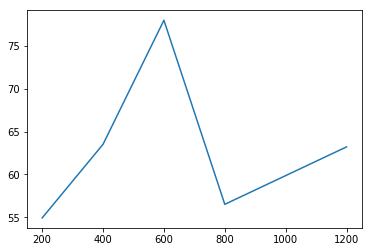

In [16]:
import matplotlib.pyplot as plt
a = [200,400,600,800,1200]
b = [54.91641065105108, 63.50855610201711, 77.98442949576143, 56.50292315293274, 63.204705663890465]
plt.plot(a,b)

In [15]:
s = pd.DataFrame([(1,2,3),(4,5,6),(7,8,9)], columns=['a','b','c'])
s

,a,b,c
0,1,2,3
1,4,5,6
2,7,8,9


In [16]:
s['a'].mean()

4.0

In [18]:
s['a'].mean(axis=0)

4.0